In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Maze7-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■
■ □ □ □ ■
■ □ ■ □ ■
■ □ ■ □ ■
■ A ■ □ ■
■ $ ■ ■ ■
■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 42 s, sys: 776 ms, total: 42.8 s
Wall time: 45.9 s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

####9### 0 None None ####0###         (empty)               q: 1.0   r: 578.7  ir: 0.0    f: 578.7  exp: 275 tga: 3     talp: 24584 tav: 90.1   num: 1


001##### 0 None None 110#####         (empty)               q: 1.0   r: 842.8  ir: 0.0    f: 842.8  exp: 376 tga: 7     talp: 24546 tav: 72.5   num: 1


#0###### 4 None None #1######         (empty)               q: 1.0   r: 573.1  ir: 0.0    f: 573.1  exp: 357 tga: 11    talp: 24533 tav: 75.9   num: 1


0011011# 1 None None 1100100#         (empty)               q: 1.0   r: 857.4  ir: 0.0    f: 857.4  exp: 351 tga: 16    talp: 24521 tav: 74.8   num: 1


1100100# 5 None None 0011011#         (empty)               q: 1.0   r: 902.5  ir: 0.0    f: 902.5  exp: 826 tga: 17    talp: 24628 tav: 26.8   num: 1


###0100# 6 None None ###1011#         (empty)               q: 1.0   r: 857.4  ir: 0.0    f: 857.4  exp: 388 tga: 37    talp: 24606 tav: 66.0   num: 1


##01011# 2 None None ###0100#         (empty)               q: 1.0   r: 857.4  ir:

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population(does_anticipate_change=True)
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 4.59 s, sys: 109 ms, total: 4.7 s
Wall time: 6.52 s


### Performance

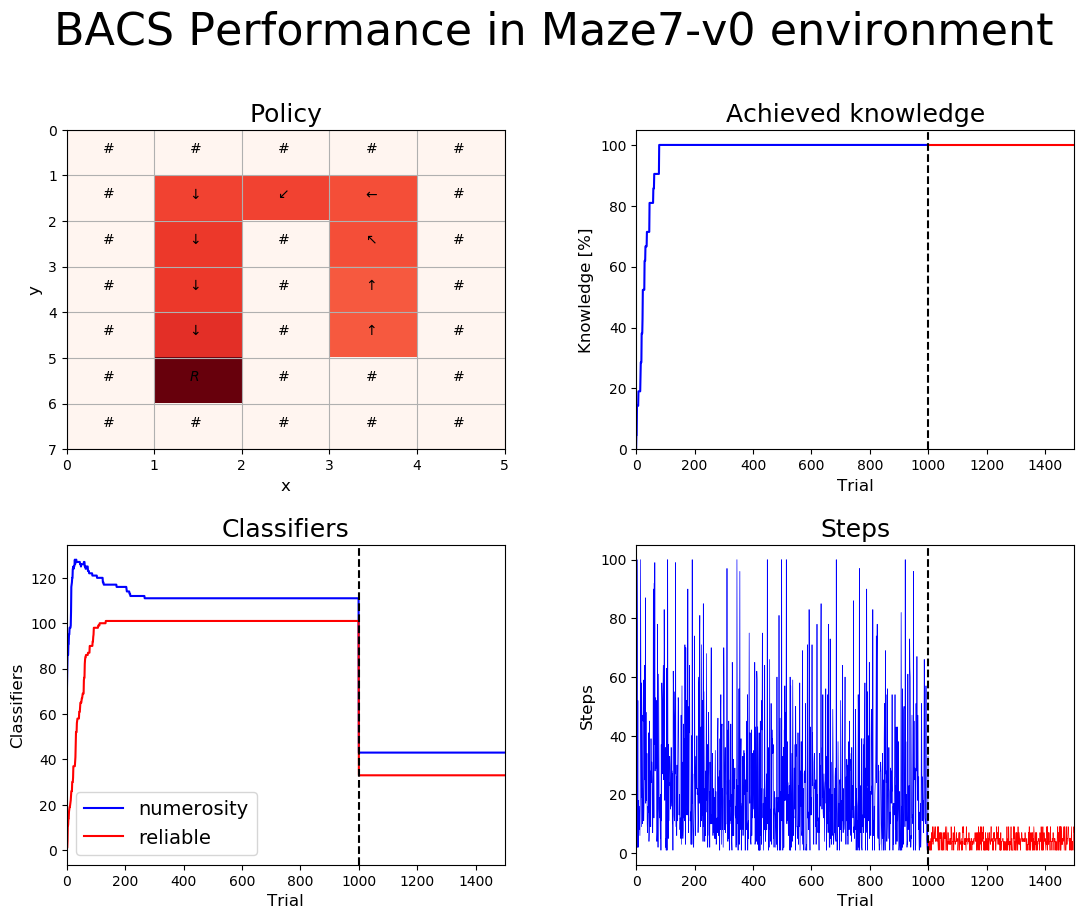

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  24.638  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  4.328  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

####9### 4 None None ####1###         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 758 tga: 229   talp: 24637 tav: 27.9   num: 1


001#0##1 4 [4] [('0', '1', '1', '1', '0', '1', '1', '1')] #1##9###         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 1196 tga: 720   talp: 24631 tav: 16.9   num: 1


1100100# 5 None None 0011011#         (empty)               q: 1.0   r: 902.5  ir: 0.0    f: 902.5  exp: 826 tga: 17    talp: 24628 tav: 26.8   num: 1


1101#### 4 None None 001#####         (empty)               q: 1.0   r: 902.5  ir: 0.0    f: 902.5  exp: 550 tga: 76    talp: 24547 tav: 54.0   num: 1


110###1# 4 None None 001#####         (empty)               q: 1.0   r: 902.5  ir: 0.0    f: 902.5  exp: 547 tga: 225   talp: 24547 tav: 54.0   num: 1


110##1## 4 None None 001#####         (empty)               q: 1.0   r: 902.5  ir: 0.0    f: 902.5  exp: 549 tga: 93    talp: 24547 tav: 54.0   num: 1


110#0### 4 None None 001#####         (empty